In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.sklearn
from collections import Counter, defaultdict
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_post = pd.read_csv('data/processed/posts_w_labels.csv')
df_post

,author,created_utc,id,link_flair_text,num_comments,permalink,score,selftext,title,name,author_fullname,word_count,created_datetime,year,sentences_topics,sentences_labels,Label,sentences
0,Ok-Slide-9849,1701251429,186lthy,NaN,2,/r/QAnonCasualties/comments/186lthy/a_belated_...,4,\tI've known about this group for a while and ...,"A belated post, does the it ever end?",t3_186lthy,t2_o416vnkb,924,1701251429000,2023,"[68, -1, -1, 0, 270, -1, 70, -1, -1, -1, -1, -...",['Social Deterioration and Relationship Strain'],['Social Deterioration and Relationship Strain'],"[""\tI've known about this group for a while an..."
1,wanderingjeannie,1660010267,wjquol,NaN,3,/r/QAnonCasualties/comments/wjquol/q_anti_vax_...,13,\n\n\nDivorce is difficult situation generally...,Q anti Vax mom using the kids to hurt the Ex h...,t3_wjquol,t2_q75aaxj9,535,1660010267000,2022,"[-1, 42, 14, -1, -1, 188, 54, -1, -1, -1, -1, ...",['Social Deterioration and Relationship Strain...,['Social Deterioration and Relationship Strain...,"[""\n\n\nDivorce is difficult situation general..."
2,Mamailla,1611614013,l4zfzt,NaN,9,/r/QAnonCasualties/comments/l4zfzt/qanon_frien...,74,\n\n\nFive years ago when Trump began his camp...,Qanon friends sound like stories from Jonestown,t3_l4zfzt,t2_2yo216d6,236,1611614013000,2021,"[-1, 12, -1, -1, 2, -1, 44, 286]",['Social Deterioration and Relationship Strain'],['Social Deterioration and Relationship Strain'],['\n\n\nFive years ago when Trump began his ca...
3,getsomeyayas,1630144463,pd70my,NaN,5,/r/QAnonCasualties/comments/pd70my/i_think_im_...,17,"\n\n\nhi, just using my throwaway to rant a li...",i think i'm beginning to lose my uncle,t3_pd70my,t2_4gftpyni,521,1630144463000,2021,"[185, -1, -1, 350, 4, -1, -1, -1, -1, 212, -1,...","['Interpersonal Harm and Moral Disregard', 'As...","['Asian and Immigrant Family Dynamics', 'Inter...","['\n\n\nhi, just using my throwaway to rant a ..."
4,f_print,1597152737,i7rvmd,NaN,11,/r/QAnonCasualties/comments/i7rvmd/looking_for...,9,\n\n*Tl;dr What is the best source for Q-Anon....,Looking for best source of QAnon material to h...,t3_i7rvmd,t2_b7t0diw,383,1597152737000,2020,"[104, -1, 37, 37, -1, 139, -1, 397, 104, 73, -...",['Radical Ideological Alignment and Intoleranc...,"['COVID-19 Lockdowns', 'YouTube Algorithms', '...",['\n\n*Tl;dr\xa0What is the best source for Q-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12742,SherlocktheWarlock,1703013286,18m9vcd,NaN,24,/r/QAnonCasualties/comments/18m9vcd/came_back_...,165,"“Well, they have to do that in order to red pi...","Came back for a shelf, left with more",t3_18m9vcd,t2_8vut8l97,615,1703013286000,2023,"[292, 159, -1, -1, 1, 49, 19, -1, 1, -1, 51, 0...",['Alternative Media Use and Information Exposu...,"['War-Inducing Rhetoric', 'Alternative Media U...","['“Well, they have to do that in order to red ..."
12743,Hot-Owl-2243,1732551047,1gzmfhy,NaN,30,/r/QAnonCasualties/comments/1gzmfhy/not_sure_i...,88,…but both my adult children are complete consp...,Not sure if it is QAnon…,t3_1gzmfhy,t2_5malttq2,179,1732551047000,2024,"[2, -1, -1, -1, -1, -1, -1, -1, -1, 252]",[],[],['…but both my adult children are complete con...
12744,Desperate-Thing1784,1693987388,16be8b5,NaN,2,/r/QAnonCasualties/comments/16be8b5/crazy_thin...,1,"■■■■■■■■■■SHE VOTES■■■■■■■■■■■\n\n●""HE didn't ...",CRAZY THINGS MY MOM SAYS HAVE A LAUGH AND ANEU...,t3_16be8b5,t2_c3pdtjjk,261,1693987388000,2023,[-1],[],[],"['■■■■■■■■■■SHE VOTES■■■■■■■■■■■\n\n●""HE didn\..."
12745,DeekALeek,1676416318,112j2pc,NaN,21,/r/QAnonCasualties/comments/112j2pc/i_helped_a...,102,"⚠️ TRIGGER WARNING: Domestic abuse, child abus...",I Helped a Friend Move Out of her Q-Fiancé’s H...,t3_112j2pc,t2_6emlogf8,824,1676416318000,2023,"[-1, -1, -1, -1, -1, -1, -1, -1, 20, -1, -1, -...","['Physical Health Disorders', 'Physical Health...",['Radical Ideological Alignment and Intoleranc...,"['⚠️ TRIGGER WARNING: Domestic abuse, child ab..."


In [3]:
import ast
df_post['Label'] = df_post['Label'].apply(ast.literal_eval)

In [4]:
df_post = df_post[df_post.Label.apply(len)>0]
len(df_post)

10860

In [5]:
post2labels = df_post['Label'].to_dict()

In [6]:
post2labels

{0: ['Social Deterioration and Relationship Strain'],
 1: ['Social Deterioration and Relationship Strain',
  'Child Harm and Elite Abuse Narratives'],
 2: ['Social Deterioration and Relationship Strain'],
 3: ['Asian and Immigrant Family Dynamics',
  'Interpersonal Harm and Moral Disregard',
  'Unknown'],
 4: ['COVID-19 Lockdowns',
  'YouTube Algorithms',
  'Child Harm and Elite Abuse Narratives',
  'Radical Ideological Alignment and Intolerance'],
 6: ['Social Deterioration and Relationship Strain',
  'Public Health Mistrust and Resistance'],
 7: ['Defamatory Conspiracy Targeting Public Figures',
  'Epistemic Rigidity and Distrust in Expertise',
  'Alternative Media Use and Information Exposure',
  'Social Deterioration and Relationship Strain',
  'Conservative Political Identity',
  'Pro-Trump',
  'Unknown'],
 8: ["Trump's Election",
  'Interpersonal Harm and Moral Disregard',
  'Physical Health Disorders',
  'Pro-Trump'],
 9: ['Policy Defiance'],
 10: ['Child Harm and Elite Abuse Na

### Preparation for LDA

In [7]:
# Initialize variables
documents = []
post_ids = []
vectorizer = None
doc_term_matrix = None
lda_models = {}
metrics = {}

In [8]:
def prepare_documents():
    """Convert post2labels to documents where each topic is a 'word'"""
    print("Preparing documents...")
    
    for post_id, topics in post2labels.items():
        # Join topics with spaces to create a "document"
        # Each topic becomes a "word" in the document
        document = ' '.join([topic.replace(' ', '_') for topic in topics])
        documents.append(document)
        post_ids.append(post_id)
    
    print(f"Created {len(documents)} documents")
    print(f"Example document: {documents[0]}")
    
    # Create vocabulary stats
    all_topics = [topic for topics in post2labels.values() for topic in topics]
    topic_counts = Counter(all_topics)
    
    print(f"\nTopic Statistics:")
    print(f"Total unique topics: {len(topic_counts)}")
    print(f"Average topics per post: {np.mean([len(topics) for topics in post2labels.values()]):.2f}")
    print(f"Most common topics:")
    for topic, count in topic_counts.most_common(10):
        print(f"  {topic}: {count} posts")

In [10]:
def create_document_term_matrix():
    """Create document-term matrix using CountVectorizer"""
    print("\nCreating document-term matrix...")
    
    # Use CountVectorizer to create the matrix
    # Each "word" is actually a topic, and we want to count topic occurrences
    vectorizer = CountVectorizer(
        token_pattern=r'[^_\s]+(?:_[^_\s]+)*',  # Match topics with underscores
        lowercase=False,  # Keep original casing
        min_df=2,  # Topic must appear in at least 2 documents
        max_df=0.95  # Topic can't appear in more than 95% of documents
    )
    
    doc_term_matrix = vectorizer.fit_transform(documents)
    
    print(f"Document-term matrix shape: {doc_term_matrix.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
    
    # Show sparsity
    sparsity = 1 - (doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1]))
    print(f"Matrix sparsity: {sparsity:.4f}")
    return vectorizer, doc_term_matrix

In [11]:
# Prepare the data
prepare_documents()
vectorizer, doc_term_matrix = create_document_term_matrix()

Preparing documents...
Created 10860 documents
Example document: Social_Deterioration_and_Relationship_Strain

Topic Statistics:
Total unique topics: 49
Average topics per post: 2.90
Most common topics:
  Social Deterioration and Relationship Strain: 3861 posts
  Public Health Mistrust and Resistance: 3761 posts
  Interpersonal Harm and Moral Disregard: 1973 posts
  COVID-19 Lockdowns: 1801 posts
  Unknown: 1714 posts
  Radical Ideological Alignment and Intolerance: 1558 posts
  Pro-Trump: 1432 posts
  Child Harm and Elite Abuse Narratives: 1272 posts
  Conservative Political Identity: 1175 posts
  Epistemic Rigidity and Distrust in Expertise: 1133 posts

Creating document-term matrix...
Document-term matrix shape: (10860, 49)
Vocabulary size: 49
Matrix sparsity: 0.9408


### Define metrics for evaluation

To run LDA over a range of k (number of clusters), we need to define several metrics for evaluation
- Commonly used: coherence score, silhoutte score, log-likelihood
- Extra (implemented in other papers): pairwise cosine similarities among clusters

In [12]:
def calculate_coherence_score(lda_model, top_n=10):
    """
    Calculate coherence score for LDA model using PMI (Pointwise Mutual Information)
    This measures how semantically similar the high-scoring topics are in each persona
    """
    feature_names = vectorizer.get_feature_names_out()
    
    # Get document-term matrix as array for easier manipulation
    doc_term_array = doc_term_matrix.toarray()
    
    coherence_scores = []
    
    for persona_id in range(lda_model.n_components):
        # Get top topics for this persona
        topic_probs = lda_model.components_[persona_id]
        top_topic_indices = topic_probs.argsort()[-top_n:][::-1]
        
        # Calculate PMI for all pairs of top topics
        pmi_scores = []
        
        for i, topic_i in enumerate(top_topic_indices):
            for j, topic_j in enumerate(top_topic_indices):
                if i < j:  # Avoid duplicate pairs
                    # Count co-occurrences
                    topic_i_docs = doc_term_array[:, topic_i] > 0
                    topic_j_docs = doc_term_array[:, topic_j] > 0
                    
                    # Joint probability
                    co_occurrence = np.sum(topic_i_docs & topic_j_docs)
                    p_ij = (co_occurrence + 1) / (len(doc_term_array) + 1)  # Add-one smoothing
                    
                    # Individual probabilities
                    p_i = (np.sum(topic_i_docs) + 1) / (len(doc_term_array) + 1)
                    p_j = (np.sum(topic_j_docs) + 1) / (len(doc_term_array) + 1)
                    
                    # PMI calculation
                    pmi = np.log(p_ij / (p_i * p_j))
                    pmi_scores.append(pmi)
        
        # Average PMI for this persona
        if pmi_scores:
            persona_coherence = np.mean(pmi_scores)
            coherence_scores.append(persona_coherence)
    
    return np.mean(coherence_scores)

def calculate_pairwise_similarity(lda_model):
    """
    Calculate average pairwise cosine similarity between persona topic distributions
    Lower similarity indicates more distinct personas
    """
    # Get persona-topic distributions
    persona_topics = lda_model.components_  # Shape: (n_personas, n_topics)
    
    # Calculate pairwise cosine similarities
    similarities = cosine_similarity(persona_topics)
    
    # Extract upper triangular part (excluding diagonal)
    n_personas = persona_topics.shape[0]
    pairwise_sims = []
    
    for i in range(n_personas):
        for j in range(i + 1, n_personas):
            pairwise_sims.append(similarities[i, j])
    
    return np.mean(pairwise_sims) if pairwise_sims else 0

### Fitting LDA Models

Now we can fit LDA and calculate the metrics

In [13]:
def fit_lda_models(doc_term_matrix, k_range=range(4, 21), random_state=42):
    """Fit LDA models for different numbers of topics"""
    print(f"\nFitting LDA models for k = {list(k_range)}")
    
    metrics = {
        'k': [],
        'perplexity': [],
        'log_likelihood': [],
        'silhouette_score': [],
        'coherence_score': [],
        'avg_pairwise_similarity': []
    }
    
    for k in k_range:
        print(f"Fitting LDA with k={k}...")
        
        # Fit LDA model
        lda = LatentDirichletAllocation(
            n_components=k,
            random_state=random_state,
            max_iter=100,
            learning_method='batch',
            evaluate_every=10,
            verbose=0
        )
        
        lda.fit(doc_term_matrix)
        
        # Store model
        lda_models[k] = lda
        
        # Calculate metrics
        perplexity = lda.perplexity(doc_term_matrix)
        log_likelihood = lda.score(doc_term_matrix)
        
        # Get document-topic probabilities for silhouette score
        doc_topic_probs = lda.transform(doc_term_matrix)
        
        # Use argmax to get hard assignments for silhouette score
        if k > 1:  # silhouette score needs at least 2 clusters
            hard_assignments = np.argmax(doc_topic_probs, axis=1)
            sil_score = silhouette_score(doc_topic_probs, hard_assignments)
        else:
            sil_score = 0
        
        # Calculate coherence score
        coherence_score = calculate_coherence_score(lda)
        
        # Calculate average pairwise similarity
        avg_pairwise_sim = calculate_pairwise_similarity(lda)
        
        # Store metrics
        metrics['k'].append(k)
        metrics['perplexity'].append(perplexity)
        metrics['log_likelihood'].append(log_likelihood)
        metrics['silhouette_score'].append(sil_score)
        metrics['coherence_score'].append(coherence_score)
        metrics['avg_pairwise_similarity'].append(avg_pairwise_sim)
        
        print(f"  Perplexity: {perplexity:.2f}, Log-likelihood: {log_likelihood:.2f}")
        print(f"  Silhouette: {sil_score:.3f}, Coherence: {coherence_score:.3f}, Avg Pairwise Sim: {avg_pairwise_sim:.3f}")
    return metrics

Visualization functions:

In [14]:
def plot_metrics(metrics, figsize=(20, 8)):
    """Plot metrics to help choose optimal k"""
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Perplexity (lower is better)
    axes[0].plot(metrics['k'], metrics['perplexity'], 'b-o')
    axes[0].set_xlabel('Number of Personas (k)')
    axes[0].set_ylabel('Perplexity')
    axes[0].set_title('Perplexity vs Number of Personas\n(Lower is better)')
    axes[0].grid(True, alpha=0.3)
    
    # Log-likelihood (higher is better)
    axes[1].plot(metrics['k'], metrics['log_likelihood'], 'g-o')
    axes[1].set_xlabel('Number of Personas (k)')
    axes[1].set_ylabel('Log-likelihood')
    axes[1].set_title('Log-likelihood vs Number of Personas\n(Higher is better)')
    axes[1].grid(True, alpha=0.3)
    
    # Silhouette score (higher is better)
    axes[2].plot(metrics['k'], metrics['silhouette_score'], 'r-o')
    axes[2].set_xlabel('Number of Personas (k)')
    axes[2].set_ylabel('Silhouette Score')
    axes[2].set_title('Silhouette Score vs Number of Personas\n(Higher is better)')
    axes[2].grid(True, alpha=0.3)
    
    # Coherence score (higher is better)
    axes[3].plot(metrics['k'], metrics['coherence_score'], 'purple', marker='o')
    axes[3].set_xlabel('Number of Personas (k)')
    axes[3].set_ylabel('Coherence Score')
    axes[3].set_title('Coherence Score vs Number of Personas\n(Higher is better)')
    axes[3].grid(True, alpha=0.3)
    
    # Average pairwise similarity (lower is better - more distinct)
    axes[4].plot(metrics['k'], metrics['avg_pairwise_similarity'], 'orange', marker='o')
    axes[4].set_xlabel('Number of Personas (k)')
    axes[4].set_ylabel('Avg Pairwise Similarity')
    axes[4].set_title('Average Pairwise Similarity\n(Lower is better - more distinct)')
    axes[4].grid(True, alpha=0.3)
    
    # Combined score (normalized metrics)
    # Normalize all metrics to 0-1 scale for combination
    metrics_array = np.array([
        metrics['silhouette_score'],
        metrics['coherence_score'],
        [-x for x in metrics['perplexity']],  # Negative because lower is better
        metrics['log_likelihood'],
        [-x for x in metrics['avg_pairwise_similarity']]  # Negative because lower is better
    ])
    
    # Min-max normalization
    normalized_metrics = np.zeros_like(metrics_array)
    for i in range(metrics_array.shape[0]):
        min_val = np.min(metrics_array[i])
        max_val = np.max(metrics_array[i])
        if max_val != min_val:
            normalized_metrics[i] = (metrics_array[i] - min_val) / (max_val - min_val)
        else:
            normalized_metrics[i] = 0.5  # If all values are the same
    
    # Combined score (average of normalized metrics)
    combined_score = np.mean(normalized_metrics, axis=0)
    
    axes[5].plot(metrics['k'], combined_score, 'black', marker='o', linewidth=2)
    axes[5].set_xlabel('Number of Personas (k)')
    axes[5].set_ylabel('Combined Score')
    axes[5].set_title('Combined Score\n(Higher is better)')
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    best_sil_k = metrics['k'][np.argmax(metrics['silhouette_score'])]
    best_coh_k = metrics['k'][np.argmax(metrics['coherence_score'])]
    best_dist_k = metrics['k'][np.argmin(metrics['avg_pairwise_similarity'])]
    best_combined_k = metrics['k'][np.argmax(combined_score)]
    
    print(f"\nRecommendations based on metrics:")
    print(f"Best silhouette score: k={best_sil_k} (score: {max(metrics['silhouette_score']):.3f})")
    print(f"Best coherence score: k={best_coh_k} (score: {max(metrics['coherence_score']):.3f})")
    print(f"Most distinct personas (lowest pairwise similarity): k={best_dist_k} (similarity: {min(metrics['avg_pairwise_similarity']):.3f})")
    print(f"Best combined score: k={best_combined_k} (score: {max(combined_score):.3f})")
    
    # Look for elbow in perplexity
    perplexities = np.array(metrics['perplexity'])
    k_values = np.array(metrics['k'])
    
    # Simple elbow detection: look for largest decrease
    decreases = np.diff(perplexities)
    elbow_idx = np.argmax(-decreases)  # Largest decrease (most negative)
    elbow_k = k_values[elbow_idx + 1]
    
    print(f"Perplexity elbow point: k={elbow_k}")
    
    return {
        'best_silhouette_k': best_sil_k,
        'best_coherence_k': best_coh_k,
        'best_distinctiveness_k': best_dist_k,
        'best_combined_k': best_combined_k,
        'perplexity_elbow_k': elbow_k
    }


Fitting LDA models for k = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Fitting LDA with k=4...
  Perplexity: 32.32, Log-likelihood: -109522.05
  Silhouette: 0.537, Coherence: 0.282, Avg Pairwise Sim: 0.156
Fitting LDA with k=5...
  Perplexity: 34.59, Log-likelihood: -111663.64
  Silhouette: 0.512, Coherence: 0.335, Avg Pairwise Sim: 0.162
Fitting LDA with k=6...
  Perplexity: 35.70, Log-likelihood: -112663.26
  Silhouette: 0.477, Coherence: 0.399, Avg Pairwise Sim: 0.151
Fitting LDA with k=7...
  Perplexity: 38.27, Log-likelihood: -114847.00
  Silhouette: 0.458, Coherence: 0.363, Avg Pairwise Sim: 0.127
Fitting LDA with k=8...
  Perplexity: 39.51, Log-likelihood: -115854.62
  Silhouette: 0.454, Coherence: 0.385, Avg Pairwise Sim: 0.132
Fitting LDA with k=9...
  Perplexity: 41.52, Log-likelihood: -117420.14
  Silhouette: 0.422, Coherence: 0.352, Avg Pairwise Sim: 0.090
Fitting LDA with k=10...
  Perplexity: 41.59, Log-likelihood: -117472.71
  Silhouette: 0.423, Coherence: 0.283, Avg Pai

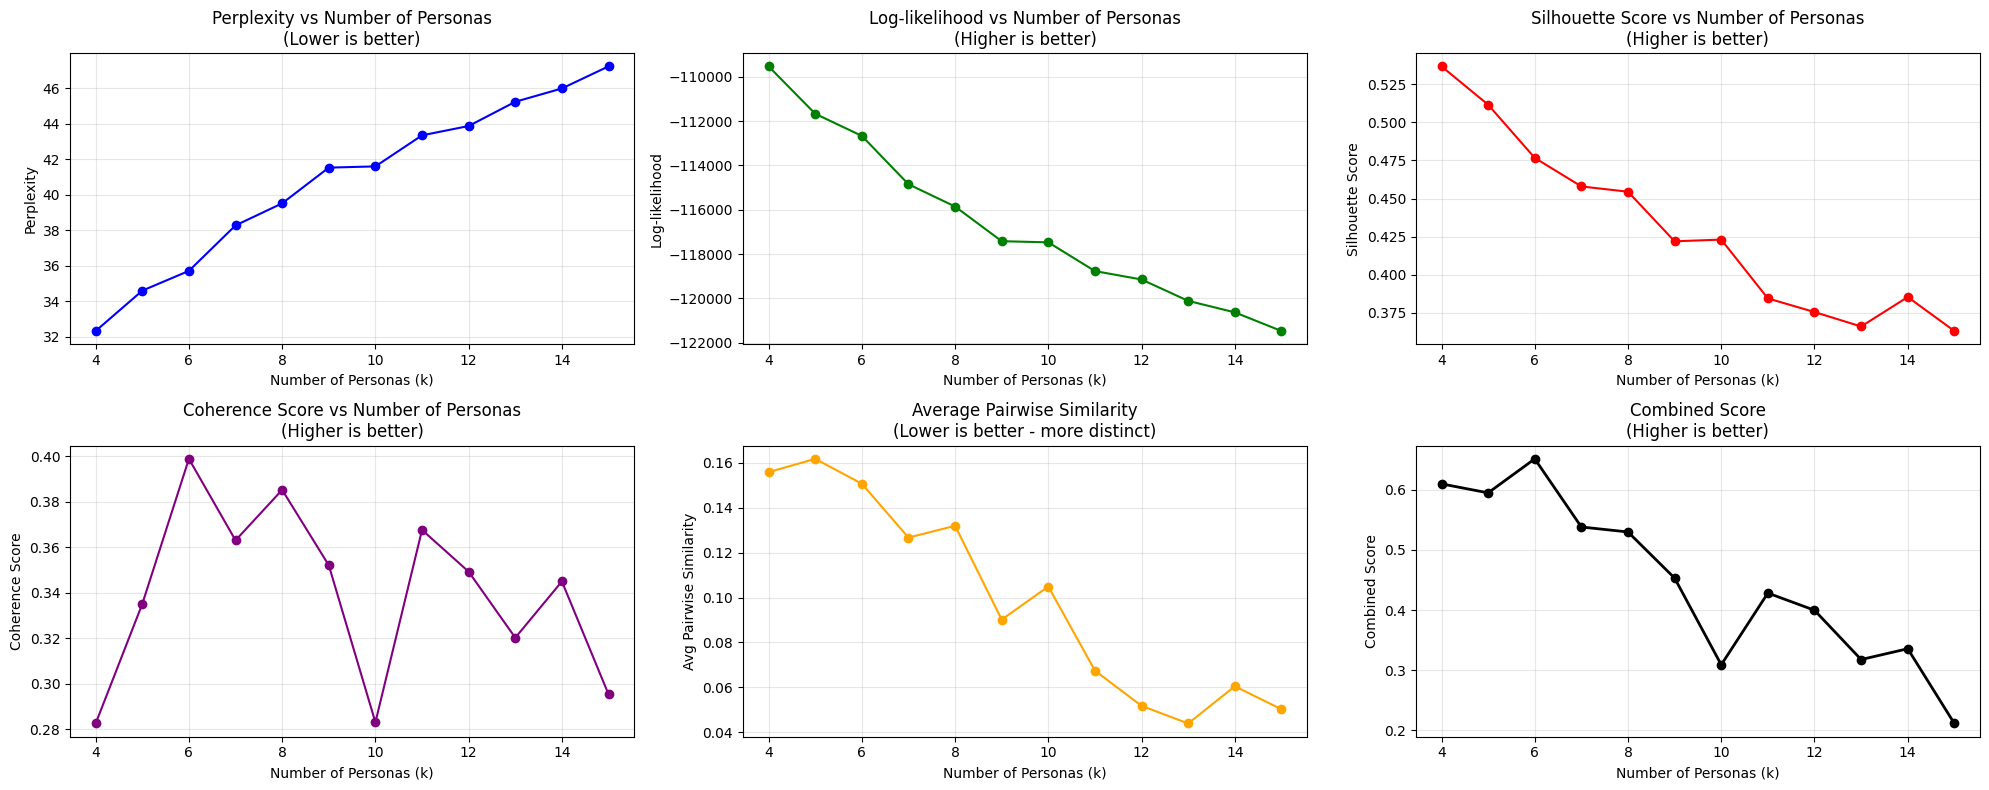


Recommendations based on metrics:
Best silhouette score: k=4 (score: 0.537)
Best coherence score: k=6 (score: 0.399)
Most distinct personas (lowest pairwise similarity): k=13 (similarity: 0.044)
Best combined score: k=6 (score: 0.652)
Perplexity elbow point: k=10


{'best_silhouette_k': 4,
 'best_coherence_k': 6,
 'best_distinctiveness_k': 13,
 'best_combined_k': 6,
 'perplexity_elbow_k': 10}

In [16]:
# Fit models for different k values
metrics = fit_lda_models(doc_term_matrix, k_range=range(4, 16))

# Plot metrics to choose optimal k
plot_metrics(metrics)

### Analyze personas

From the metric plot, we saw that k=6 seems to be the best.

In [19]:
def analyze_personas(k, top_topics=10):
    """Analyze personas for a specific k"""
    if k not in lda_models:
        raise ValueError(f"Model for k={k} not found. Run fit_lda_models first.")
        
    lda = lda_models[k]
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"\n=== PERSONA ANALYSIS FOR k={k} ===")
    
    # Get document-topic probabilities
    doc_topic_probs = lda.transform(doc_term_matrix)
    
    # Assign each document to most likely persona
    persona_assignments = np.argmax(doc_topic_probs, axis=1)
    
    # Document distribution across personas
    persona_counts = Counter(persona_assignments)
    print(f"\nDocument distribution across personas:")
    for persona_id in sorted(persona_counts.keys()):
        count = persona_counts[persona_id]
        percentage = (count / len(persona_assignments)) * 100
        print(f"  Persona {persona_id}: {count} documents ({percentage:.1f}%)")
    
    # Analyze each persona
    persona_profiles = {}
    
    for persona_id in range(k):
        print(f"\n--- PERSONA {persona_id} ---")
        
        # Get top topics for this persona
        topic_probs = lda.components_[persona_id]
        top_topic_indices = topic_probs.argsort()[-top_topics:][::-1]
        top_topics_list = [(feature_names[i].replace('_', ' '), topic_probs[i]) 
                          for i in top_topic_indices]
        
        print(f"Top {top_topics} topics (with probabilities):")
        for topic, prob in top_topics_list:
            print(f"  {topic}: {prob:.3f}")
        
        # Store persona profile
        persona_profiles[persona_id] = {
            'top_topics': top_topics_list,
            'document_count': persona_counts[persona_id],
            'percentage': (persona_counts[persona_id] / len(persona_assignments)) * 100
        }
        
        # Find representative documents
        persona_docs = np.where(persona_assignments == persona_id)[0]
        if len(persona_docs) > 0:
            # Get documents with highest probability for this persona
            persona_doc_probs = doc_topic_probs[persona_docs, persona_id]
            top_doc_indices = persona_doc_probs.argsort()[-3:][::-1]  # Top 3 most representative
            
            print(f"\nMost representative posts:")
            for i, doc_idx in enumerate(top_doc_indices):
                actual_post_id = post_ids[persona_docs[doc_idx]]
                prob = persona_doc_probs[doc_idx]
                
                # Get post content
                try:
                    post_content = df_post.loc[actual_post_id, 'selftext']
                    # Truncate if too long
                    if len(post_content) > 5000:
                        post_content = post_content[:5000] + "..."
                    print(f"  {i+1}. Post {actual_post_id} (prob: {prob:.3f})")
                    print(f"     Topics: {post2labels[actual_post_id]}")
                    print(f"     Content: {post_content}")
                    print()
                except:
                    print(f"  {i+1}. Post {actual_post_id} (prob: {prob:.3f}) - Content not available")
    
    return persona_profiles, persona_assignments, doc_topic_probs

In [46]:
k_chosen = 8
persona_profiles, assignments, doc_topic_probs = analyze_personas(k_chosen)


=== PERSONA ANALYSIS FOR k=8 ===

Document distribution across personas:
  Persona 0: 1823 documents (16.8%)
  Persona 1: 1546 documents (14.2%)
  Persona 2: 1323 documents (12.2%)
  Persona 3: 1590 documents (14.6%)
  Persona 4: 1221 documents (11.2%)
  Persona 5: 1367 documents (12.6%)
  Persona 6: 1017 documents (9.4%)
  Persona 7: 973 documents (9.0%)

--- PERSONA 0 ---
Top 10 topics (with probabilities):
  Social Deterioration and Relationship Strain: 1375.274
  Public Health Mistrust and Resistance: 777.138
  Unknown: 736.344
  Physical Health Disorders: 664.125
  Substance Use and Abuse: 393.125
  Interpersonal Harm and Moral Disregard: 359.581
  Mental Health Disorders: 148.125
  Perceived Personal Goodness: 143.125
  Financial Struggles and Housing Instability: 93.125
  Holistic and Alternative Medicine Beliefs: 0.125

Most representative posts:
  1. Post 7258 (prob: 0.854)
     Topics: ['Public Health Mistrust and Resistance', 'Substance Use and Abuse', 'Social Deterioration

In [47]:
k_chosen = 6  # Choose based on metrics
persona_profiles, assignments, doc_topic_probs = analyze_personas(k_chosen)


=== PERSONA ANALYSIS FOR k=6 ===

Document distribution across personas:
  Persona 0: 1990 documents (18.3%)
  Persona 1: 1869 documents (17.2%)
  Persona 2: 1337 documents (12.3%)
  Persona 3: 1772 documents (16.3%)
  Persona 4: 1653 documents (15.2%)
  Persona 5: 2239 documents (20.6%)

--- PERSONA 0 ---
Top 10 topics (with probabilities):
  Social Deterioration and Relationship Strain: 1485.679
  Public Health Mistrust and Resistance: 828.840
  Unknown: 818.167
  Physical Health Disorders: 664.165
  Interpersonal Harm and Moral Disregard: 444.393
  Substance Use and Abuse: 393.165
  (Un)employment and Retirement Status: 240.164
  Perceived Personal Goodness: 143.164
  Perceived High Intelligence: 140.164
  Financial Struggles and Housing Instability: 93.165

Most representative posts:
  1. Post 1017 (prob: 0.861)
     Topics: ['Public Health Mistrust and Resistance', '(Un)employment and Retirement Status', 'Substance Use and Abuse', 'Physical Health Disorders', 'Unknown']
     Cont

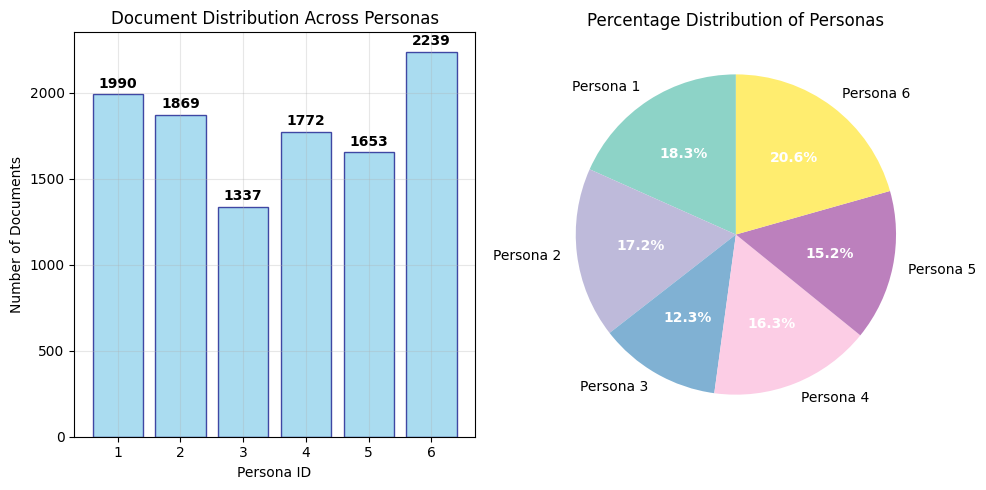


=== CLUSTER DISTRIBUTION STATISTICS (k=6) ===
Total documents: 10860
Number of personas: 6

Persona | Documents | Percentage | Cumulative %
--------------------------------------------------
    1   |    1990   |    18.3%   |    18.3%
    2   |    1869   |    17.2%   |    35.5%
    3   |    1337   |    12.3%   |    47.8%
    4   |    1772   |    16.3%   |    64.2%
    5   |    1653   |    15.2%   |    79.4%
    6   |    2239   |    20.6%   |   100.0%
--------------------------------------------------

Distribution Statistics:
Mean cluster size: 1810.0
Std cluster size: 279.8
Min cluster size: 1337
Max cluster size: 2239
Balance ratio (min/max): 0.597
Normalized entropy: 0.993 (1.0 = perfectly balanced)


In [21]:
def plot_cluster_distribution(persona_assignments, k, figsize=(10, 5)):
    """
    Plot distribution of cluster sizes and show statistics
    
    Args:
        persona_assignments: array of persona assignments for each document
        k: number of personas
        figsize: figure size for plots
    """
    from collections import Counter
    
    # Count documents per persona
    persona_counts = Counter(persona_assignments)
    
    # Ensure all personas are represented (even if count is 0)
    for i in range(k):
        if i not in persona_counts:
            persona_counts[i] = 0
    
    # Sort by persona ID
    personas = sorted(persona_counts.keys())
    counts = [persona_counts[p] for p in personas]
    percentages = [count / len(persona_assignments) * 100 for count in counts]
    
    # Change indexing from 0-5 to 1-6 for plotting
    personas = [p+1 for p in personas]
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Bar plot of counts
    bars1 = ax1.bar(personas, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.set_xlabel('Persona ID')
    ax1.set_ylabel('Number of Documents')
    ax1.set_title('Document Distribution Across Personas')
    ax1.set_xticks(personas)
    ax1.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars1, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(counts),
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart of percentages
    colors = plt.cm.Set3(np.linspace(0, 1, k))
    wedges, texts, autotexts = ax2.pie(percentages, 
                                       labels=[f'Persona {i}' for i in personas],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    ax2.set_title('Percentage Distribution of Personas')
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n=== CLUSTER DISTRIBUTION STATISTICS (k={k}) ===")
    print(f"Total documents: {len(persona_assignments)}")
    print(f"Number of personas: {k}")
    print()
    
    # Statistics table
    print("Persona | Documents | Percentage | Cumulative %")
    print("-" * 50)
    cumulative = 0
    for i, (persona, count, pct) in enumerate(zip(personas, counts, percentages)):
        cumulative += pct
        print(f"   {persona:2d}   |   {count:5d}   |   {pct:5.1f}%   |   {cumulative:5.1f}%")
    
    print("-" * 50)
    
    # Distribution statistics
    print(f"\nDistribution Statistics:")
    print(f"Mean cluster size: {np.mean(counts):.1f}")
    print(f"Std cluster size: {np.std(counts):.1f}")
    print(f"Min cluster size: {min(counts)}")
    print(f"Max cluster size: {max(counts)}")
    
    # Balance metrics
    balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
    print(f"Balance ratio (min/max): {balance_ratio:.3f}")
    
    # Entropy (higher = more balanced)
    entropy = -sum(p/100 * np.log2(p/100) for p in percentages if p > 0)
    max_entropy = np.log2(k)
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    print(f"Normalized entropy: {normalized_entropy:.3f} (1.0 = perfectly balanced)")
    
    # Check for very small clusters
    small_clusters = [i for i, count in enumerate(counts) if count < len(persona_assignments) * 0.01]  # < 1%
    if small_clusters:
        print(f"\nWarning: Very small clusters (< 1%): {small_clusters}")
    
    return {
        'counts': counts,
        'percentages': percentages,
        'balance_ratio': balance_ratio,
        'normalized_entropy': normalized_entropy
    }

stats = plot_cluster_distribution(assignments, k=6)

In [22]:
def create_persona_heatmap(k, figsize=(12, 8)):
    """Create heatmap showing persona-topic relationships"""
    if k not in lda_models:
        raise ValueError(f"Model for k={k} not found. Run fit_lda_models first.")
        
    lda = lda_models[k]
    feature_names = vectorizer.get_feature_names_out()
    
    # Create heatmap data
    heatmap_data = lda.components_
    
    # Clean up feature names (remove underscores)
    clean_feature_names = [name.replace('_', ' ') for name in feature_names]
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, 
               xticklabels=clean_feature_names,
               yticklabels=[f'Persona {i}' for i in range(k)],
               cmap='YlOrRd',
               cbar_kws={'label': 'Topic Probability'})
    
    plt.title(f'Persona-Topic Probability Heatmap (k={k})')
    plt.xlabel('Topics')
    plt.ylabel('Personas')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

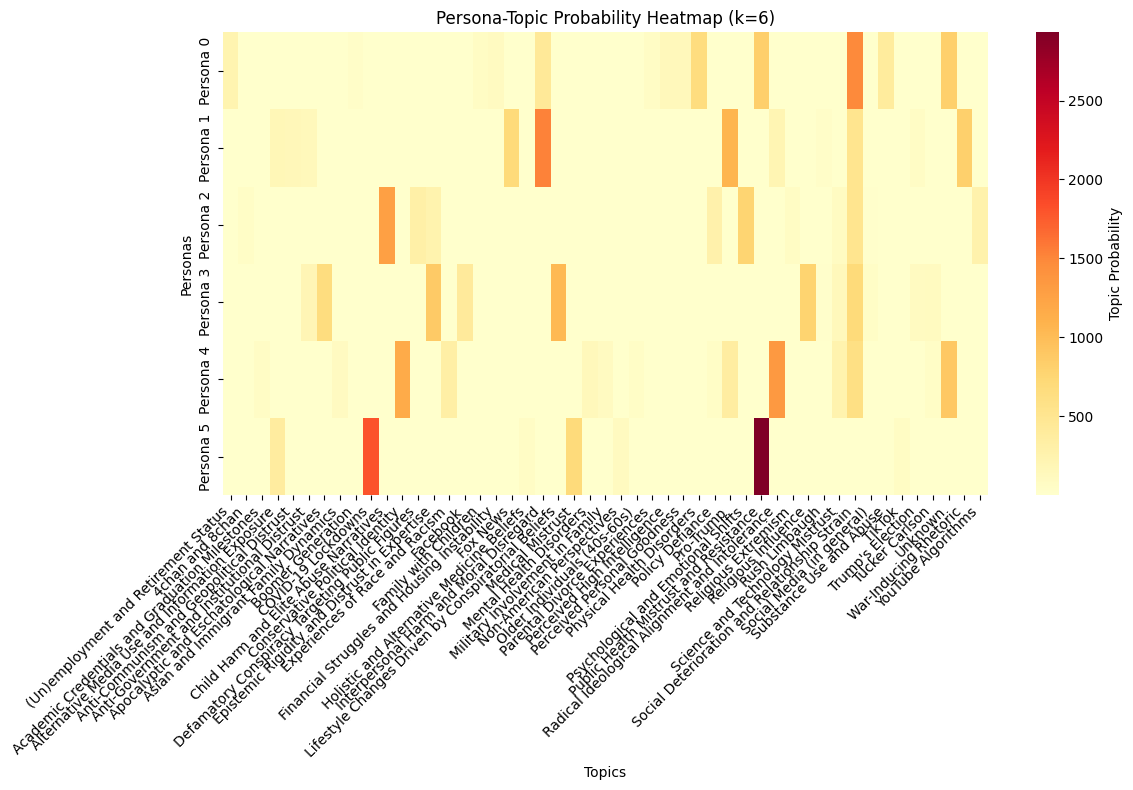

In [23]:
# Create heatmap
create_persona_heatmap(k_chosen)

### Personas overtime

In [24]:
def plot_persona_timeline(k, assignments, time_unit='month'):
    """
    Plot persona prevalence over time
    
    Args:
        k: number of personas
        assignments: persona assignments from analyze_personas()
        time_unit: 'month', 'quarter', or 'year' for time aggregation
    """
    if k not in lda_models:
        raise ValueError(f"Model for k={k} not found.")
    
    # Create DataFrame with post_id, persona, and timestamp
    timeline_data = []
    for i, post_id in enumerate(post_ids):
        try:
            created_utc = df_post.loc[post_id, 'created_utc']
            timeline_data.append({
                'post_id': post_id,
                'persona': assignments[i],
                'created_utc': created_utc
            })
        except:
            continue  # Skip if timestamp not available
    
    df_timeline = pd.DataFrame(timeline_data)
    
    # Convert timestamp to datetime
    df_timeline['datetime'] = pd.to_datetime(df_timeline['created_utc'], unit='s')
    
    # Create time period column
    if time_unit == 'month':
        df_timeline['time_period'] = df_timeline['datetime'].dt.to_period('M')
    elif time_unit == 'quarter':
        df_timeline['time_period'] = df_timeline['datetime'].dt.to_period('Q')
    elif time_unit == 'year':
        df_timeline['time_period'] = df_timeline['datetime'].dt.to_period('Y')
    
    # Count posts per persona per time period
    # Fix indexing from 0-5 to 1-6 for plotting
    df_timeline['persona_plot'] = df_timeline['persona'].apply(lambda x: x+1)
    persona_counts = df_timeline.groupby(['time_period', 'persona_plot']).size().unstack(fill_value=0)
    
    # Calculate percentages
    persona_percentages = persona_counts.div(persona_counts.sum(axis=1), axis=0) * 100
    
    # Create subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    
    persona_counts.plot(kind='line', ax=ax1, marker='o', linewidth=1, markersize=4)
    ax1.set_title(f'Persona Prevalence Over Time (Absolute Counts) - {time_unit.capitalize()}ly')
    ax1.set_xlabel(f'Time Period ({time_unit.capitalize()})')
    ax1.set_ylabel('Number of Posts')
    ax1.legend(title='Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTimeline Summary:")
    print(f"Date range: {df_timeline['datetime'].min().strftime('%Y-%m-%d')} to {df_timeline['datetime'].max().strftime('%Y-%m-%d')}")
    print(f"Total posts with timestamps: {len(df_timeline)}")
    print(f"Time periods covered: {len(persona_counts)}")
    
    # Find trends
    print(f"\nPersona Trends:")
    for persona_id in range(1, k+1):
        if persona_id in persona_counts.columns:
            trend_data = persona_counts[persona_id]
            if len(trend_data) > 1:
                correlation = np.corrcoef(range(len(trend_data)), trend_data)[0,1]
                trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
                print(f"  Persona {persona_id}: {trend_direction} trend (correlation: {correlation:.3f})")
    
    return df_timeline, persona_counts, persona_percentages

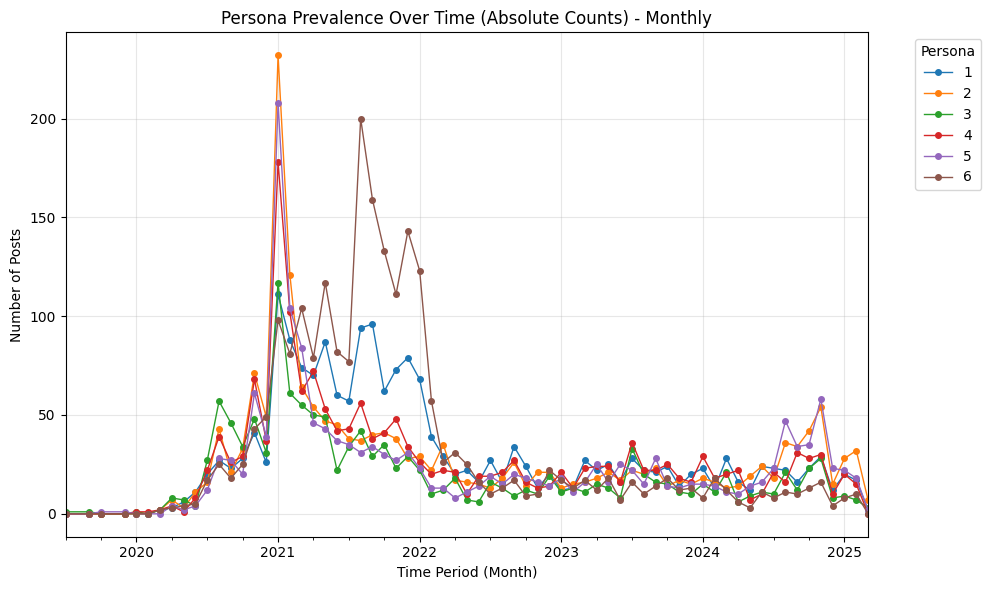


Timeline Summary:
Date range: 2019-07-29 to 2025-03-04
Total posts with timestamps: 10860
Time periods covered: 67

Persona Trends:
  Persona 1: decreasing trend (correlation: -0.146)
  Persona 2: stable trend (correlation: -0.080)
  Persona 3: decreasing trend (correlation: -0.219)
  Persona 4: decreasing trend (correlation: -0.134)
  Persona 5: stable trend (correlation: -0.048)
  Persona 6: decreasing trend (correlation: -0.245)


In [25]:
# Plot timeline
df_timeline, counts, percentages = plot_persona_timeline(k=6, assignments=assignments, time_unit='month')

### Assigning persona probabilities to each post

In [41]:
def add_persona_probabilities_to_df(df_post, k=6):
    """
    Add persona probabilities as columns to the original DataFrame
    
    Args:
        df_post: Original DataFrame with posts
        k: Number of personas (6 in this case)
    
    Returns:
        df_post with added persona probability columns
    """
    
    # Get the fitted LDA model for k=6
    lda_model = lda_models[k]
    
    # Get document-topic probabilities for all posts
    doc_topic_probs = lda_model.transform(doc_term_matrix)
    
    # Create a mapping from post_id to probabilities
    post_id_to_probs = {}
    for i, post_id in enumerate(post_ids):
        post_id_to_probs[post_id] = doc_topic_probs[i]
    
    # Add columns to DataFrame
    for persona_id in range(k):
        column_name = f'persona_{persona_id}_prob'
        
        # Initialize column with NaN
        df_post[column_name] = np.nan
        
        # Fill in probabilities for posts that have topic labels
        for post_id, probs in post_id_to_probs.items():
            if post_id in df_post.index:
                df_post.loc[post_id, column_name] = probs[persona_id]
    
    # Also add the most likely persona assignment
    df_post['dominant_persona'] = np.nan
    for post_id, probs in post_id_to_probs.items():
        if post_id in df_post.index:
            df_post.loc[post_id, 'dominant_persona'] = np.argmax(probs)
    
    print(f"Added {k} persona probability columns and 1 dominant persona column to DataFrame")
    print(f"New columns: {[f'persona_{i}_prob' for i in range(k)] + ['dominant_persona']}")
    
    # Show some statistics
    print(f"\nDominant persona distribution:")
    persona_counts = df_post['dominant_persona'].value_counts().sort_index()
    for persona_id, count in persona_counts.items():
        if not pd.isna(persona_id):
            percentage = (count / len(post_id_to_probs)) * 100
            print(f"  Persona {int(persona_id)}: {count} posts ({percentage:.1f}%)")
    
    return df_post

In [42]:
df_post_w_persona = df_post.copy(deep=True)
df_post_w_persona = add_persona_probabilities_to_df(df_post_w_persona, k=6)

Added 6 persona probability columns and 1 dominant persona column to DataFrame
New columns: ['persona_0_prob', 'persona_1_prob', 'persona_2_prob', 'persona_3_prob', 'persona_4_prob', 'persona_5_prob', 'dominant_persona']

Dominant persona distribution:
  Persona 0: 1990 posts (18.3%)
  Persona 1: 1869 posts (17.2%)
  Persona 2: 1337 posts (12.3%)
  Persona 3: 1772 posts (16.3%)
  Persona 4: 1653 posts (15.2%)
  Persona 5: 2239 posts (20.6%)


In [48]:
df_post_w_persona.sample(5)

,author,created_utc,id,link_flair_text,num_comments,permalink,score,selftext,title,name,...,sentences_labels,Label,sentences,persona_0_prob,persona_1_prob,persona_2_prob,persona_3_prob,persona_4_prob,persona_5_prob,dominant_persona
1556,throwaway556837385,1628953840,p49r4c,NaN,117,/r/QAnonCasualties/comments/p49r4c/i_feel_like...,1253,For context I’m in the military and I’m statio...,I feel like I’m watching my family descend int...,t3_p49r4c,...,"['Facebook', 'Child Harm and Elite Abuse Narra...","[Anti-Communism and Geopolitical Distrust, Fac...",['For context I’m in the military and I’m stat...,0.041667,0.291661,0.291671,0.291667,0.041667,0.041667,2.0
4711,Gabsi006,1658577615,w62cm4,NaN,25,/r/QAnonCasualties/comments/w62cm4/my_sisters_...,220,I need help dealing with my sisters father-in-...,My sisters Father-in-law is a bad influence fo...,t3_w62cm4,...,"['COVID-19 Lockdowns', 'Public Health Mistrust...","[Public Health Mistrust and Resistance, COVID-...",['I need help dealing with my sisters father-i...,0.055668,0.055556,0.055556,0.055556,0.055556,0.722109,5.0
1981,throwallqs,1667834261,yopzuv,NaN,70,/r/QAnonCasualties/comments/yopzuv/update_to_q...,590,"Hello everyone, \n\nThanks a lot for your comm...",Update to: Q adjacent partner and vaccinating ...,t3_yopzuv,...,"['Public Health Mistrust and Resistance', 'Ant...","[Social Deterioration and Relationship Strain,...","['Hello everyone, \n\nThanks a lot for your co...",0.042512,0.042050,0.041931,0.540189,0.041883,0.291436,3.0
1220,[deleted],1610480096,kvyu2b,NaN,129,/r/QAnonCasualties/comments/kvyu2b/i_think_the...,93,Do you remember the Ashley Madison leak? Well ...,I think the Parler leak (80TB) and it not bein...,t3_kvyu2b,...,['Alternative Media Use and Information Exposu...,"[Interpersonal Harm and Moral Disregard, War-I...","['Do you remember the Ashley Madison leak?', '...",0.033372,0.633019,0.033333,0.233333,0.033333,0.033609,1.0
1287,Craftymammax2,1631204236,pl0zsi,NaN,220,/r/QAnonCasualties/comments/pl0zsi/sick_q_mom/,796,EDIT: \nShe got tested today! We should have r...,Sick Q Mom,t3_pl0zsi,...,['Social Deterioration and Relationship Strain...,"[Social Deterioration and Relationship Strain,...","['EDIT: \nShe got tested today!', 'We should h...",0.387371,0.055857,0.055982,0.055998,0.055903,0.388889,5.0


In [111]:
df_post_w_persona.to_pickle("data/oon/df_post_w_persona.pkl")

### "Pureness" of personas?

In [44]:
def analyze_persona_mixing(df_post, k=6, threshold=None):
    """
    Analyze how mixed personas are using Gini coefficient and role occupation
    
    Args:
        df_post: DataFrame with persona probability columns
        k: Number of personas
        threshold: Threshold for considering a persona as "occupied" (default: 1/k)
    
    Returns:
        Dictionary with analysis results
    """
    
    if threshold is None:
        threshold = 1/k
    
    print(f"Analyzing persona mixing with k={k}, threshold={threshold:.3f}")
    print("=" * 60)
    
    # Get probability columns
    prob_cols = [f'persona_{i}_prob' for i in range(k)]
    
    # Filter posts that have persona probabilities
    posts_with_personas = df_post.dropna(subset=prob_cols)
    
    if len(posts_with_personas) == 0:
        print("No posts found with persona probabilities")
        return None
    
    # Calculate occupied roles for each post
    occupied_roles = []
    role_counts = []
    
    for _, row in posts_with_personas.iterrows():
        probs = [row[col] for col in prob_cols]
        
        # Count how many personas are above threshold
        occupied = sum(1 for prob in probs if prob > threshold)
        occupied_roles.append(occupied)
        role_counts.append(probs)
    
    # Calculate Gini coefficient
    gini_coeff = calculate_gini_coefficient(occupied_roles)
    
    # Count distribution of occupied roles
    role_distribution = Counter(occupied_roles)
    
    print(f"Persona Mixing Analysis Results:")
    print(f"  Total posts analyzed: {len(posts_with_personas)}")
    print(f"  Threshold for occupation: {threshold:.3f}")
    print(f"  Gini coefficient: {gini_coeff:.3f}")
    print(f"  Average occupied personas per post: {np.mean(occupied_roles):.2f}")
    print(f"  Standard deviation: {np.std(occupied_roles):.2f}")
    
    print(f"\nDistribution of occupied personas:")
    for num_roles in sorted(role_distribution.keys()):
        count = role_distribution[num_roles]
        percentage = (count / len(occupied_roles)) * 100
        print(f"  {num_roles} persona(s): {count} posts ({percentage:.1f}%)")
    
    # Interpret Gini coefficient
    print(f"\nGini Coefficient Interpretation:")
    if gini_coeff < 0.2:
        print("  Low inequality: Most posts have similar persona mixing patterns")
    elif gini_coeff < 0.4:
        print("  Moderate inequality: Some variation in persona mixing")
    elif gini_coeff < 0.6:
        print("  High inequality: Clear distinction between pure and mixed posts")
    else:
        print("  Very high inequality: Extreme variation in persona mixing")
    
    return {
        'gini_coefficient': gini_coeff,
        'occupied_roles': occupied_roles,
        'role_distribution': role_distribution,
        'threshold': threshold,
        'mean_occupied': np.mean(occupied_roles),
        'std_occupied': np.std(occupied_roles)
    }

def calculate_gini_coefficient(values):
    """Calculate Gini coefficient for a list of values"""
    values = np.array(values)
    n = len(values)
    
    if n == 0:
        return 0
    
    # Sort values
    sorted_values = np.sort(values)
    
    # Calculate Gini coefficient
    cumsum = np.cumsum(sorted_values)
    gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
    
    return gini

def plot_persona_mixing(df_post, k=6, threshold=None, figsize=(12, 8)):
    """
    Create visualizations for persona mixing analysis
    
    Args:
        df_post: DataFrame with persona probability columns
        k: Number of personas
        threshold: Threshold for considering a persona as "occupied"
        figsize: Figure size for plots
    """
    
    if threshold is None:
        threshold = 1/k
    
    # Get analysis results
    results = analyze_persona_mixing(df_post, k, threshold)
    
    if results is None:
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Bar chart of occupied roles distribution (like Figure 2 in the paper)
    role_dist = results['role_distribution']
    roles = sorted(role_dist.keys())
    percentages = [(role_dist[role] / sum(role_dist.values())) * 100 for role in roles]
    
    axes[0, 0].bar(roles, percentages, color='skyblue', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Occupied Personas')
    axes[0, 0].set_ylabel('Percentage of Posts (%)')
    axes[0, 0].set_title(f'Distribution of Occupied Personas\n(Threshold: {threshold:.3f})')
    axes[0, 0].set_xticks(range(1, k+1))
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (role, pct) in enumerate(zip(roles, percentages)):
        axes[0, 0].text(role, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom')
    
    # 2. Histogram of occupied roles
    axes[0, 1].hist(results['occupied_roles'], bins=range(1, k+2), alpha=0.7, color='lightcoral')
    axes[0, 1].set_xlabel('Number of Occupied Personas')
    axes[0, 1].set_ylabel('Number of Posts')
    axes[0, 1].set_title('Histogram of Occupied Personas')
    axes[0, 1].set_xticks(range(1, k+1))
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Persona probability distribution
    prob_cols = [f'persona_{i}_prob' for i in range(k)]
    prob_data = df_post[prob_cols].dropna()
    
    axes[1, 0].boxplot([prob_data[col] for col in prob_cols], 
                       labels=[f'P{i}' for i in range(k)])
    axes[1, 0].set_xlabel('Persona')
    axes[1, 0].set_ylabel('Probability')
    axes[1, 0].set_title('Persona Probability Distributions')
    axes[1, 0].axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                       label=f'Threshold ({threshold:.3f})')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Gini coefficient visualization
    occupied_sorted = sorted(results['occupied_roles'])
    n = len(occupied_sorted)
    lorenz_curve = np.cumsum(occupied_sorted) / sum(occupied_sorted)
    equality_line = np.arange(1, n+1) / n
    
    axes[1, 1].plot(equality_line, lorenz_curve, 'b-', linewidth=2, label='Lorenz Curve')
    axes[1, 1].plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect Equality')
    axes[1, 1].fill_between(equality_line, lorenz_curve, equality_line, alpha=0.3)
    axes[1, 1].set_xlabel('Cumulative Share of Posts')
    axes[1, 1].set_ylabel('Cumulative Share of Occupied Personas')
    axes[1, 1].set_title(f'Lorenz Curve\n(Gini = {results["gini_coefficient"]:.3f})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_pure_vs_mixed_posts(df_post, k=6, threshold=None, n_examples=3):
    """
    Analyze and show examples of pure vs mixed posts
    
    Args:
        df_post: DataFrame with persona probability columns
        k: Number of personas
        threshold: Threshold for considering a persona as "occupied"
        n_examples: Number of examples to show for each category
    """
    
    if threshold is None:
        threshold = 1/k
    
    prob_cols = [f'persona_{i}_prob' for i in range(k)]
    posts_with_personas = df_post.dropna(subset=prob_cols)
    
    # Calculate occupied roles
    occupied_counts = []
    for _, row in posts_with_personas.iterrows():
        probs = [row[col] for col in prob_cols]
        occupied = sum(1 for prob in probs if prob > threshold)
        occupied_counts.append(occupied)
    
    posts_with_personas = posts_with_personas.copy()
    posts_with_personas['occupied_count'] = occupied_counts
    
    # Find pure posts (occupy only 1 persona)
    pure_posts = posts_with_personas[posts_with_personas['occupied_count'] == 1]
    
    # Find mixed posts (occupy multiple personas)
    mixed_posts = posts_with_personas[posts_with_personas['occupied_count'] > 1]
    
    print(f"Pure vs Mixed Posts Analysis:")
    print("=" * 40)
    print(f"Pure posts (1 persona): {len(pure_posts)} ({len(pure_posts)/len(posts_with_personas)*100:.1f}%)")
    print(f"Mixed posts (2+ personas): {len(mixed_posts)} ({len(mixed_posts)/len(posts_with_personas)*100:.1f}%)")
    
    # Show examples of pure posts
    if len(pure_posts) > 0:
        print(f"\nExamples of PURE posts:")
        print("-" * 30)
        for i, (post_id, row) in enumerate(pure_posts.head(n_examples).iterrows()):
            dominant_persona = int(row['dominant_persona'])
            max_prob = row[f'persona_{dominant_persona}_prob']
            
            print(f"Post {post_id} - Dominant: Persona {dominant_persona} ({max_prob:.3f})")
            
            # Show all probabilities
            probs = [row[col] for col in prob_cols]
            prob_str = ", ".join([f"P{i}:{p:.3f}" for i, p in enumerate(probs)])
            print(f"  Probabilities: {prob_str}")
            
            if 'selftext' in df_post.columns:
                content = str(row['selftext'])[:150]
                print(f"  Content: {content}...")
            print()
    
    # Show examples of mixed posts
    if len(mixed_posts) > 0:
        print(f"\nExamples of MIXED posts:")
        print("-" * 30)
        # Sort by number of occupied personas (most mixed first)
        mixed_sorted = mixed_posts.sort_values('occupied_count', ascending=False)
        
        for i, (post_id, row) in enumerate(mixed_sorted.head(n_examples).iterrows()):
            occupied_count = row['occupied_count']
            
            print(f"Post {post_id} - Occupies {occupied_count} personas")
            
            # Show all probabilities
            probs = [row[col] for col in prob_cols]
            prob_str = ", ".join([f"P{i}:{p:.3f}" for i, p in enumerate(probs)])
            print(f"  Probabilities: {prob_str}")
            
            # Show which personas are occupied
            occupied_personas = [i for i, p in enumerate(probs) if p > threshold]
            print(f"  Occupied personas: {occupied_personas}")
            
            if 'selftext' in df_post.columns:
                content = str(row['selftext'])[:150]
                print(f"  Content: {content}...")
            print()

Analyzing persona mixing with k=6, threshold=0.167
Persona Mixing Analysis Results:
  Total posts analyzed: 10860
  Threshold for occupation: 0.167
  Gini coefficient: 0.237
  Average occupied personas per post: 1.70
  Standard deviation: 0.78

Distribution of occupied personas:
  1 persona(s): 5189 posts (47.8%)
  2 persona(s): 3935 posts (36.2%)
  3 persona(s): 1512 posts (13.9%)
  4 persona(s): 222 posts (2.0%)
  5 persona(s): 2 posts (0.0%)

Gini Coefficient Interpretation:
  Moderate inequality: Some variation in persona mixing
Analyzing persona mixing with k=6, threshold=0.167
Persona Mixing Analysis Results:
  Total posts analyzed: 10860
  Threshold for occupation: 0.167
  Gini coefficient: 0.237
  Average occupied personas per post: 1.70
  Standard deviation: 0.78

Distribution of occupied personas:
  1 persona(s): 5189 posts (47.8%)
  2 persona(s): 3935 posts (36.2%)
  3 persona(s): 1512 posts (13.9%)
  4 persona(s): 222 posts (2.0%)
  5 persona(s): 2 posts (0.0%)

Gini Coeffi

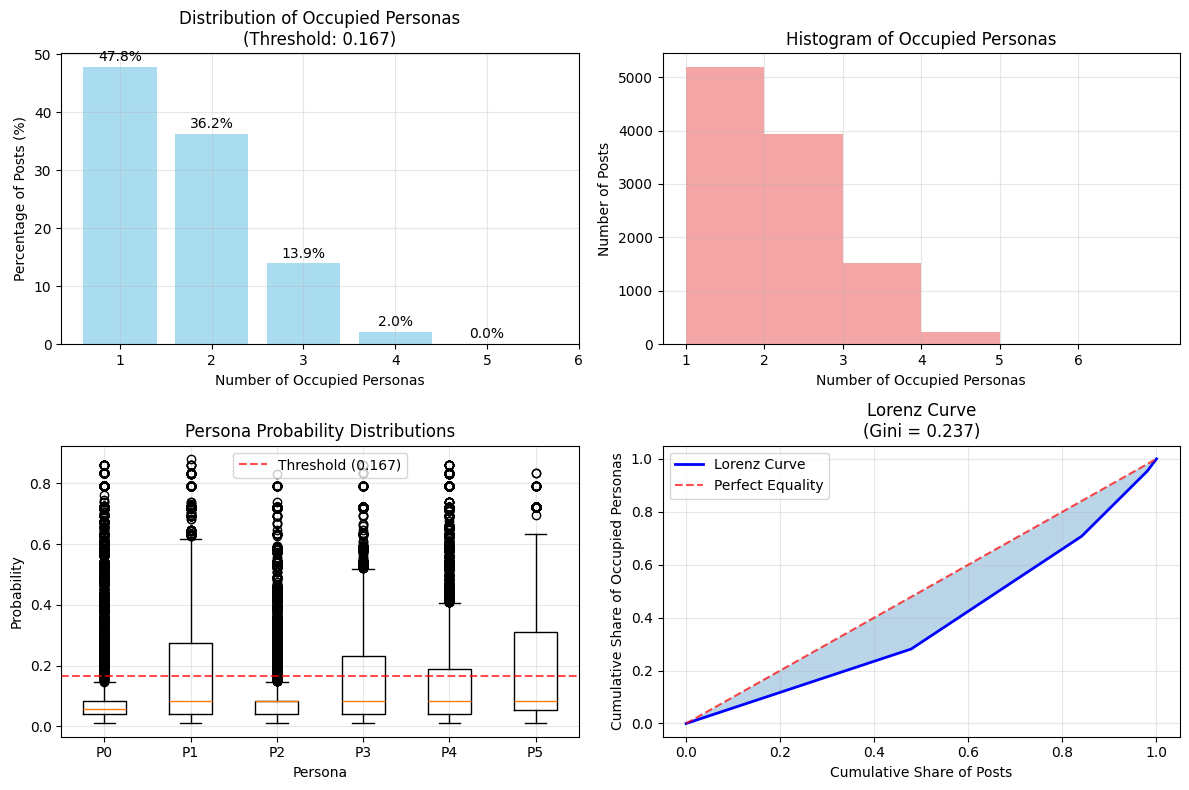

Pure vs Mixed Posts Analysis:
Pure posts (1 persona): 5189 (47.8%)
Mixed posts (2+ personas): 5671 (52.2%)

Examples of PURE posts:
------------------------------
Post 0 - Dominant: Persona 0 (0.581)
  Probabilities: P0:0.581, P1:0.084, P2:0.084, P3:0.084, P4:0.084, P5:0.083
  Content: 	I've known about this group for a while and haven't doing anything as I am still in shock in some ways. My ex-wife went down the path of QANON starti...

Post 1 - Dominant: Persona 2 (0.720)
  Probabilities: P0:0.056, P1:0.056, P2:0.720, P3:0.056, P4:0.056, P5:0.056
  Content: 


Divorce is difficult situation generally, but it's so much worse when the kids become pieces of the game. As an adult, ending a relationship,  you ...

Post 2 - Dominant: Persona 0 (0.581)
  Probabilities: P0:0.581, P1:0.084, P2:0.084, P3:0.084, P4:0.084, P5:0.083
  Content: 


Five years ago when Trump began his campaign I was concerned immediately. Having read stories from Jonestown survivors and family members of lost l...



In [45]:
# Run the main analysis
results = analyze_persona_mixing(df_post_w_persona, k=6)

# Create visualizations
plot_persona_mixing(df_post_w_persona, k=6)

# Analyze pure vs mixed posts
analyze_pure_vs_mixed_posts(df_post_w_persona, k=6)

Gini coefficient of 0.237 is moderate-low quality. This suggests that most posts in the dataset have relatively similar persona mixing patterns, with some but not extreme variation. This might indicate how **radicalization is typically a multi-faceted process rather than following single, isolated pathways**. Most people's radicalization stories involve combinations of themes (like social media + conspiracy theories + social isolation) rather than being purely about one aspect.

In [52]:
lda_models[6].

LatentDirichletAllocation(evaluate_every=10, max_iter=100, n_components=6,
                          random_state=42)

In [69]:
# Save top 10 keywords for viz
topics6_final = []
lda_final = lda_models[6]
feature_names = vectorizer.get_feature_names_out()
# Analyze each persona
persona_profiles = {}

for persona_id in range(6):
    # Get top 10 topics for this persona
    topic_probs = lda_final.components_[persona_id]
    top_topic_indices = topic_probs.argsort()[-10:][::-1]
    top_topics_list = [(feature_names[i].replace('_', ' ')) 
                      for i in top_topic_indices]
    topics6_final.append(top_topics_list)

In [70]:
import pickle

with open('data-lda-final/topics6_final', 'wb') as fp:
    pickle.dump(topics6_final, fp)